In [13]:
import warnings # ignore warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from wordcloud import WordCloud

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer


from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',
                 encoding="ISO-8859-1")
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
# # renaming column
# df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Manufacturer'}, inplace=True)

In [8]:
# defining dictionary map and mapping
driver_operator_map = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service1': 'Apple',
    
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'}

df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].map(driver_operator_map)
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN       5837
Apple     2374
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
df['emotion_in_tweet_is_directed_at'].value_counts(dropna=False)

NaN       5837
Apple     2374
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [10]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [12]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [15]:
def process_string(text):
    """This function returns a processed list of words from the given text
    
    This function removes html elements and urls using regular expression, then
    converts string to list of workds, them find the stem of words in the list of words and
    finally removes stopwords and punctuation marks from list of words.
    
    Args:
        text(string): The text from which html elements, urls, stopwords, punctuation are removed and stemmed
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    
    # Remove any urls from the text
    text = re.sub(r"https:\/\/.*[\r\n]*",
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r"www\.\w*\.\w\w\w",
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove prediods  marks
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
 
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    
    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer  = WordNetLemmatizer()
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [16]:
X_train = X_train['tweet_text'].apply(process_string)
X_test = X_test['tweet_text'].apply(process_string)

In [17]:
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [188]:
# df['is_there_an_emotion_directed_at_a_brand_or_product'] = label_encoder.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
# df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()


1    5389
2    2978
0     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [22]:
tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(X_train.tolist())
X_test = tf_idf.transform(X_test.tolist())

print(X_train.shape, X_test.shape)

(5987, 7048) (2950, 7048)


              precision    recall  f1-score   support

           -       0.00      0.00      0.00       195
     Neutral       0.61      1.00      0.76      1791
           +       0.00      0.00      0.00       964

    accuracy                           0.61      2950
   macro avg       0.20      0.33      0.25      2950
weighted avg       0.37      0.61      0.46      2950



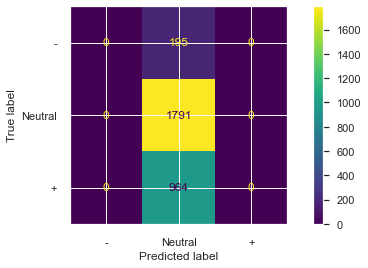

In [25]:
# Create Dummy/Baseliner
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)


# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['-', 'Neutral', '+']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['-', 'Neutral', '+']
print(classification_report(y_test, y_pred, target_names=target_names))

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   29.4s finished


Mean Training Score: 78.71%

Mean Test Score: 68.68%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 69.11%

              precision    recall  f1-score   support

           -       0.46      0.20      0.28       195
     Neutral       0.73      0.82      0.77      1791
           +       0.61      0.53      0.57       964

    accuracy                           0.69      2950
   macro avg       0.60      0.52      0.54      2950
weighted avg       0.67      0.69      0.67      2950



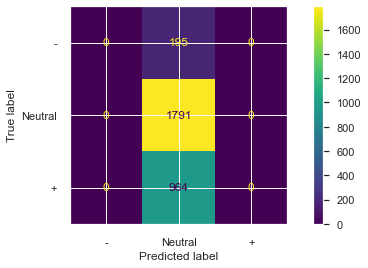

In [26]:
pipe = Pipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])



param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']



grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)



# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)



print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")


# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['-', 'Neutral', '+']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['-', 'Neutral', '+']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');

In [49]:
def text_contains(df):
    i = 0
    if df["tweet_text"][i].contains(['ipad', 'iphone', 'apple', 'mac', 'ios']) in df:
        df['emotion_in_tweet_is_directed_at'][i] = 'Apple'
        i += 1
    elif df["tweet_text"][i].contains(['google', 'andriod', 'pixel']):
        df['emotion_in_tweet_is_directed_at'][i] = 'Google'
        i += 1
    else:
        i += 1

In [72]:
def text_contains(df):
    i = 0
    for df["tweet_text"][i] in df:
        if 'ipad' or 'iphone' or 'apple' or 'mac' or 'ios' in df["tweet_text"][i]:
            df['emotion_in_tweet_is_directed_at'][i] = 'Apple'
            i += 1
        elif 'google' or 'andriod' or 'pixel' in df["tweet_text"][i]:
            df['emotion_in_tweet_is_directed_at'][i] = 'Google'
            i += 1
        else:
            i += 1

In [123]:
# df.drop(df.index[-1])

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,t,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product


In [14]:
X = df.drop(columns=["emotion_in_tweet_is_directed_at", "is_there_an_emotion_directed_at_a_brand_or_product"])
y = df.drop(columns=["emotion_in_tweet_is_directed_at", "tweet_text"])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [199]:
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train), print(y_test)

[1 1 1 ... 1 2 1]
[2 2 2 ... 1 1 1]


(None, None)

In [200]:
tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(X_train["tweet_text"].tolist())
X_test = tf_idf.transform(X_test["tweet_text"].tolist())

print(X_train.shape, X_test.shape)

(5987, 7048) (2950, 7048)


                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       195
No emotion toward brand or product       0.61      1.00      0.76      1791
                  Positive emotion       0.00      0.00      0.00       964

                          accuracy                           0.61      2950
                         macro avg       0.20      0.33      0.25      2950
                      weighted avg       0.37      0.61      0.46      2950



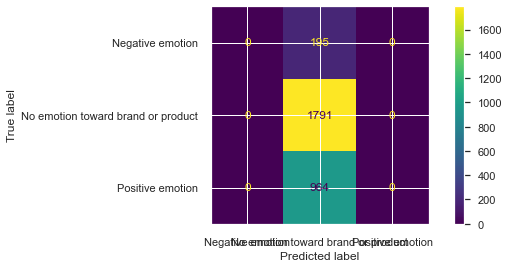

In [201]:
# Create Dummy/Baseliner
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)


# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Negative emotion', 'No emotion toward brand or product', 'Positive emotion']
print(classification_report(y_test, y_pred, target_names=target_names))

In [202]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

1    5389
2    2978
0     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   19.8s finished


Mean Training Score: 78.71%

Mean Test Score: 68.68%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 69.11%

              precision    recall  f1-score   support

           -       0.46      0.20      0.28       195
     Neutral       0.73      0.82      0.77      1791
           +       0.61      0.53      0.57       964

    accuracy                           0.69      2950
   macro avg       0.60      0.52      0.54      2950
weighted avg       0.67      0.69      0.67      2950



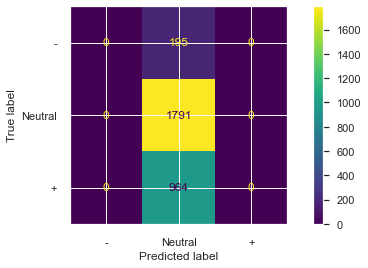

In [203]:
pipe = Pipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])



param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']



grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)



# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)



print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")


# Set figsize and font scale
sns.set(rc={'figure.figsize':(9, 4)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['-', 'Neutral', '+']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['-', 'Neutral', '+']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_LogReg');

In [95]:
# # Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# # The regex pattern should select all words with three or more characters
# # pattern = r"(?u)\w{3,}"
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# # Create a list of stopwords in English
# stopwords_list = stopwords.words('english')

# # Create an instance of nltk's PorterStemmer with the variable name `stemmer`
# lemmatizer = WordNetLemmatizer()

In [96]:
# def get_wordnet_pos(treebank_tag):
#     '''
#     Translate nltk POS to wordnet tags
#     '''
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

In [104]:
# def preprocess_text(df, tokenizer, stopwords_list, lemmatizer):
#     # Standardize case (lowercase the text)
#     lowered = df[col].lower()
    
#     # Tokenize text using `tokenizer`
#     tokens = tokenizer.tokenize(lowered)
    
#     # Remove stopwords using `stopwords_list`
#     stopped_tokens = [word for word in tokens if word not in stopwords_list]
    
#     pos = pos_tag(stopped_tokens)
#     pos = [(word[0], get_wordnet_pos(word[1])) for word in pos]
    
#     # Stem the tokenized text using `stemmer`
#     lemmas = [lemmatizer.lemmatize(word[0], word[1]) for word in pos]
    
#     # Return the preprocessed text
#     return lemmas

In [175]:
def process_string(text):
    """This function returns a processed list of words from the given text
    
    This function removes html elements and urls using regular expression, then
    converts string to list of workds, them find the stem of words in the list of words and
    finally removes stopwords and punctuation marks from list of words.
    
    Args:
        text(string): The text from which hrml elements, urls, stopwords, punctuation are removed and stemmed
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    
    # Remove any urls from the text
    text = re.sub(r"https:\/\/.*[\r\n]*",
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r"www\.\w*\.\w\w\w",
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove prediods  marks
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
 
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    
    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer  = WordNetLemmatizer()
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

df['tweet_text'] = df['tweet_text'].apply(process_string)
df

In [176]:
df['tweet_text'] = df['tweet_text'].apply(process_string)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,wesley g iphone hr tweeting rise austin dead n...,Apple,Negative emotion
1,jessedee know fludapp awesome ipad iphone app ...,Apple,Positive emotion
2,swonderlin wait ipad also sale sxsw,Apple,Positive emotion
3,sxsw hope year's festival crashy year's iphone...,Apple,Negative emotion
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive emotion
...,...,...,...
9088,ipad everywhere sxsw link,Apple,Positive emotion
9089,wave buzz rt mention interrupt regularly sched...,NaN,No emotion toward brand or product
9090,google's zeiger physician never reported poten...,NaN,No emotion toward brand or product
9091,verizon iphone customer complained time fell b...,NaN,No emotion toward brand or product


In [144]:
df['tweet_text'][9092]

'rt mention google test check offer sxsw link'

In [146]:
df = df.reset_index()

In [147]:
df

,index,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,0,wesley g iphone hr tweeting rise austin dead n...,iPhone,Negative emotion
1,1,jessedee know fludapp awesome ipad iphone app ...,iPad or iPhone App,Positive emotion
2,2,swonderlin wait ipad also sale sxsw,iPad,Positive emotion
3,3,sxsw hope year's festival crashy year's iphone...,iPad or iPhone App,Negative emotion
4,4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive emotion
...,...,...,...,...
9088,9088,ipad everywhere sxsw link,iPad,Positive emotion
9089,9089,wave buzz rt mention interrupt regularly sched...,NaN,No emotion toward brand or product
9090,9090,google's zeiger physician never reported poten...,NaN,No emotion toward brand or product
9091,9091,verizon iphone customer complained time fell b...,NaN,No emotion toward brand or product


In [158]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False, normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [148]:
#create a new data frame with "id" and "comment" fields
df_subset = df[['index', 'is_there_an_emotion_directed_at_a_brand_or_product']].copy()
#data clean-up
#remove all non-aphabet characters
df_subset['is_there_an_emotion_directed_at_a_brand_or_product'] = df_subset['is_there_an_emotion_directed_at_a_brand_or_product'].str.replace("[^a-zA-Z#]", " ")
#covert to lower-case
df_subset['is_there_an_emotion_directed_at_a_brand_or_product'] = df_subset['is_there_an_emotion_directed_at_a_brand_or_product'].str.casefold()
print (df_subset.head(10))

   index is_there_an_emotion_directed_at_a_brand_or_product
0      0                                   negative emotion
1      1                                   positive emotion
2      2                                   positive emotion
3      3                                   negative emotion
4      4                                   positive emotion
5      5                 no emotion toward brand or product
6      6                 no emotion toward brand or product
7      7                                   positive emotion
8      8                                   positive emotion
9      9                                   positive emotion


In [149]:
# set up empty dataframe for staging output
df1 = pd.DataFrame()
df1['index'] = ['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0

In [151]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key, value, row[0]]
        df1['index'] = row[0]
        df1['sentiment_type'] = key
        df1['sentiment_score'] = value
        t_df = t_df.append(df1)
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.index != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Processing sentiment analysis...
   index sentiment_type  sentiment_score
0      0       compound          -0.5719
0      1       compound           0.5574
0      2       compound           0.5574
0      3       compound          -0.5719
0      4       compound           0.5574
0      5       compound          -0.2960
0      6       compound          -0.2960
0      7       compound           0.5574
0      8       compound           0.5574
0      9       compound           0.5574


In [155]:
#merge dataframes
df = pd.merge(df, t_df_cleaned, on='index', how='inner')
print(df_output.head(10))

   index                                         tweet_text  \
0      0  wesley g iphone hr tweeting rise austin dead n...   
1      1  jessedee know fludapp awesome ipad iphone app ...   
2      2                swonderlin wait ipad also sale sxsw   
3      3  sxsw hope year's festival crashy year's iphone...   
4      4  sxtxstate great stuff fri sxsw marissa mayer g...   
5      5  teachntech new ipad apps speechtherapy communi...   
6      6                                                nan   
7      7  sxsw starting ctia around corner googleio hop ...   
8      8  beautifully smart simple idea rt madebymany th...   
9      9  counting day sxsw plus strong canadian dollar ...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   
5                             NaN   
6                             NaN   
7         

In [157]:
df.head(50)

,index,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,sentiment_type_x,sentiment_score_x,sentiment_type_y,sentiment_score_y
0,0,wesley g iphone hr tweeting rise austin dead n...,Apple,Negative emotion,compound,-0.5719,compound,-0.5719
1,1,jessedee know fludapp awesome ipad iphone app ...,Apple,Positive emotion,compound,0.5574,compound,0.5574
2,2,swonderlin wait ipad also sale sxsw,Apple,Positive emotion,compound,0.5574,compound,0.5574
3,3,sxsw hope year's festival crashy year's iphone...,Apple,Negative emotion,compound,-0.5719,compound,-0.5719
4,4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive emotion,compound,0.5574,compound,0.5574
5,5,teachntech new ipad apps speechtherapy communi...,NaN,No emotion toward brand or product,compound,-0.2960,compound,-0.2960
6,6,nan,NaN,No emotion toward brand or product,compound,-0.2960,compound,-0.2960
7,7,sxsw starting ctia around corner googleio hop ...,Google,Positive emotion,compound,0.5574,compound,0.5574
8,8,beautifully smart simple idea rt madebymany th...,Apple,Positive emotion,compound,0.5574,compound,0.5574
9,9,counting day sxsw plus strong canadian dollar ...,Apple,Positive emotion,compound,0.5574,compound,0.5574


In [122]:
process_string(df['tweet_text'][4])

'sxtxstate great stuff Fri SXSW Marissa Mayer Google Tim O Reilly tech book conference amp Matt Mullenweg Wordpress'

In [ ]:
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train), print(y_test)

In [ ]:
from PIL import Image
from wordcloud import WordCloud #library that allows word cloud to be generated

def generate_word_cloud(dataframe_df,column_name,img_file=None,background_color="black",max_words=2000):
    """ This function generates word cloud
    
    Args:
        dataframe: the datafram object which contains column whose word cloud is to be generated
        column_name: the name of the column in dataframw whose cloud is to be generated
        
    Returns:
        None
    """
    #convert the column specified by column_name in dataset_df(dataframe) to list
    sentences_list = dataframe_df[column_name].tolist()
    
    #convert a list to sentence
    #sentences_single_string = " ".join(sentences_list)
    sentences_single_string = " ".join(map(str,sentences_list))
    
    #plot word cloud
    plt.figure(figsize=(15,15))
    
    img_mask = None
    
    if img_file != None:
        img_mask = np.array(Image.open(img_file))

    wc = WordCloud(mask=img_mask,
                   max_words=max_words,
                   background_color=background_color)        
        
    plt.imshow(wc.generate(sentences_single_string),interpolation="bilinear")
    plt.title("Word Cloud For " +  column_name)
    plt.show()

In [ ]:
import time
tic= time.time()
generate_word_cloud(X_train,
                    "tweet_text",
                    background_color="black")
toc = time.time()
diff = 1000*(toc - tic)
print("Total Time Taken: " + str(diff) + " ms")

In [ ]:
X_train.to_csv("./data/X_train.csv")
X_test.to_csv("./data/X_test.csv")

In [ ]:
tf_idf = TfidfVectorizer()


X_train = tf_idf.fit_transform(X_train["tweet_text"].tolist())
X_test = tf_idf.transform(X_test["tweet_text"].tolist())

print(X_train.shape, X_test.shape)

In [ ]:
for record in df:
    if 'ipad' in record['tweet_text']:
        record['Manufacturer'] == 'Apple')
    elif 'google' in record['tweet_text']:
        record['Manufacturer'].replace('NaN', 'Google')

In [ ]:
apple = ['ipad', 'iphone', 'apple', 'mac', 'ios']
google = ['google', 'andriod', 'pixel', 'windows']

In [ ]:
df.isnull().sum()